In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
import datetime as dt
from matplotlib.colors import ListedColormap

In [98]:
# Load data - uploaded to github
df = pd.read_csv("https://raw.githubusercontent.com/ethanweinberg1002/CBH_Case_Study/refs/heads/main/CBHCase.csv", delimiter=',')

In [99]:
#Drop is_verified from the dataset completely
if 'IS_VERIFIED' in df.columns:
    df = df.drop('IS_VERIFIED', axis=1)

In [100]:
# Convert ISO dates to datetime objects
date_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 
                'CANCELED_AT', 'DELETED_AT']

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Create binary target variable from CLAIMED_AT (assuming you've marked it as 'Y' or blank)
df['is_claimed'] = df['CLAIMED_AT'].apply(lambda x: 1 if x == 'Y' else 0)

In [101]:
# IMPORTANT - Extract basic time features FIRST before using them
if 'SHIFT_START_AT' in df.columns:
    # Extract basic time features that will be used by other feature engineering steps
    df['start_hour'] = df['SHIFT_START_AT'].dt.hour
    df['start_day_of_week'] = df['SHIFT_START_AT'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['weekend'] = df['start_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Calculate posting lead time 
if 'SHIFT_CREATED_AT' in df.columns and 'SHIFT_START_AT' in df.columns:
    df['posting_lead_time'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600  # in hours

# Add time between viewing and shift start (if available)
if 'OFFER_VIEWED_AT' in df.columns and 'SHIFT_START_AT' in df.columns:
    df['view_to_start_hours'] = (df['SHIFT_START_AT'] - df['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
    # Replace infinite values with NaN
    df['view_to_start_hours'].replace([np.inf, -np.inf], np.nan, inplace=True)

# NOW add the time-based features that depend on start_hour
if 'start_hour' in df.columns:
    # Part of day indicators (one-hot encoded time slots)
    df['slot_morning'] = ((df['start_hour'] >= 5) & (df['start_hour'] < 12)).astype(int)
    df['slot_afternoon'] = ((df['start_hour'] >= 12) & (df['start_hour'] < 17)).astype(int)
    df['slot_evening'] = ((df['start_hour'] >= 17) & (df['start_hour'] < 22)).astype(int)
    df['slot_night'] = ((df['start_hour'] >= 22) | (df['start_hour'] < 5)).astype(int)
    
    # Day type features
    df['is_monday'] = (df['start_day_of_week'] == 0).astype(int)
    df['is_friday'] = (df['start_day_of_week'] == 4).astype(int)
    
# Month and season
if 'SHIFT_START_AT' in df.columns:
    df['month'] = df['SHIFT_START_AT'].dt.month
    df['quarter'] = df['SHIFT_START_AT'].dt.quarter
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
    
    # Week number in year/month
    df['week_of_year'] = df['SHIFT_START_AT'].dt.isocalendar().week
    df['day_of_month'] = df['SHIFT_START_AT'].dt.day
    df['is_start_of_month'] = (df['day_of_month'] <= 5).astype(int)
    df['is_end_of_month'] = (df['day_of_month'] >= 25).astype(int)

# Lead time and urgency metrics
if 'posting_lead_time' in df.columns:
    # Categorize lead time
    df['short_notice'] = (df['posting_lead_time'] < 24).astype(int)
    df['medium_notice'] = ((df['posting_lead_time'] >= 24) & (df['posting_lead_time'] < 72)).astype(int)
    df['long_notice'] = (df['posting_lead_time'] >= 72).astype(int)
    
    # Was shift posted on same day it occurs?
    if 'SHIFT_CREATED_AT' in df.columns and 'SHIFT_START_AT' in df.columns:
        df['same_day_posting'] = (df['SHIFT_CREATED_AT'].dt.date == df['SHIFT_START_AT'].dt.date).astype(int)
    
    # Time of day when shift was posted
    if 'SHIFT_CREATED_AT' in df.columns:
        df['posting_hour'] = df['SHIFT_CREATED_AT'].dt.hour
        df['posted_during_business_hours'] = ((df['posting_hour'] >= 9) & (df['posting_hour'] <= 17)).astype(int)
        df['posted_on_weekend'] = (df['SHIFT_CREATED_AT'].dt.dayofweek >= 5).astype(int)

# Rate and duration related features - Use correct capitalization
if 'RATE' in df.columns and 'CHARGE_RATE' in df.columns:
    # Worker margin and percentages
    df['worker_margin'] = df['RATE'] - df['CHARGE_RATE']
    df['worker_margin_percent'] = (df['worker_margin'] / df['CHARGE_RATE']) * 100
    
    # Rate comparisons (could compare to average rates)
    df['rate_to_avg_ratio'] = df['RATE'] / df['RATE'].mean()

if 'DURATION' in df.columns:
    # Duration categories
    df['short_shift'] = (df['DURATION'] <= 4).astype(int)
    df['medium_shift'] = ((df['DURATION'] > 4) & (df['DURATION'] < 8)).astype(int)
    df['long_shift'] = (df['DURATION'] >= 8).astype(int)
    
    # Total pay for shift
    if 'RATE' in df.columns:
        df['total_pay'] = df['RATE'] * df['DURATION']

# Interaction features - use correct capitalization
if all(col in df.columns for col in ['weekend', 'RATE']):
    # Premium for weekend shifts
    df['weekend_rate_interaction'] = df['weekend'] * df['RATE']

if all(col in df.columns for col in ['posting_lead_time', 'RATE']):
    # Interaction between lead time and rate
    df['lead_time_rate_interaction'] = df['posting_lead_time'] * df['RATE']

# Print column names to verify
print("Generated features. DataFrame now has these columns:")
print(df.columns.tolist())

C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\1345939366.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['view_to_start_hours'].replace([np.inf, -np.inf], np.nan, inplace=True)


Generated features. DataFrame now has these columns:
['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'DURATION', 'SLOT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT', 'IS_NCNS', 'PAY_RATE', 'CHARGE_RATE', 'is_claimed', 'start_hour', 'start_day_of_week', 'weekend', 'posting_lead_time', 'view_to_start_hours', 'slot_morning', 'slot_afternoon', 'slot_evening', 'slot_night', 'is_monday', 'is_friday', 'month', 'quarter', 'is_summer', 'is_winter', 'week_of_year', 'day_of_month', 'is_start_of_month', 'is_end_of_month', 'short_notice', 'medium_notice', 'long_notice', 'same_day_posting', 'posting_hour', 'posted_during_business_hours', 'posted_on_weekend', 'short_shift', 'medium_shift', 'long_shift']


In [102]:
# Calculate rate difference (what worker is paid vs what facility is charged)
if 'RATE' in df.columns and 'CHARGE_RATE' in df.columns:
    df['rate_difference'] = df['CHARGE_RATE'] - df['RATE']
    df['rate_ratio'] = df['RATE'] / df['CHARGE_RATE']
    # Calculate rate per hour (adjusted for duration)
    if 'DURATION' in df.columns:
        df['total_pay'] = df['RATE'] * df['DURATION']

In [103]:
# Explore categorical variables
if 'SLOT' in df.columns:
    # One-hot encode the slot variable
    df = pd.get_dummies(df, columns=['SLOT'], prefix='slot')

In [104]:
excluded_cols = ['is_claimed', 'CLAIMED_AT', 'SHIFT_START_AT', 
                'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 
                'CANCELED_AT', 'DELETED_AT']

# List remaining numeric columns for features
X_cols = [col for col in df.columns if col not in excluded_cols]
numeric_cols = []
for col in X_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        numeric_cols.append(col)
X = df[numeric_cols].copy()
y = df['is_claimed']

X = X.fillna(X.median())# List remaining numeric columns for features
X_cols = [col for col in df.columns if col not in excluded_cols]
numeric_cols = []
for col in X_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        numeric_cols.append(col)

print("\nFeatures included in the model:")
print(numeric_cols)

X = df[numeric_cols].copy()
y = df['is_claimed']

# Handle missing values - using median instead of mean to be robust against outliers
X = X.fillna(X.median())


Features included in the model:
['DURATION', 'IS_NCNS', 'PAY_RATE', 'CHARGE_RATE', 'start_hour', 'start_day_of_week', 'weekend', 'posting_lead_time', 'view_to_start_hours', 'slot_morning', 'slot_afternoon', 'slot_evening', 'slot_night', 'is_monday', 'is_friday', 'month', 'quarter', 'is_summer', 'is_winter', 'week_of_year', 'day_of_month', 'is_start_of_month', 'is_end_of_month', 'short_notice', 'medium_notice', 'long_notice', 'same_day_posting', 'posting_hour', 'posted_during_business_hours', 'posted_on_weekend', 'short_shift', 'medium_shift', 'long_shift', 'slot_am', 'slot_noc', 'slot_pm']


In [105]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model with class weight balancing
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
                         Feature  Importance
8            view_to_start_hours    0.222392
2                       PAY_RATE    0.210282
7              posting_lead_time    0.127388
3                    CHARGE_RATE    0.066838
20                  day_of_month    0.052428
27                  posting_hour    0.051220
19                  week_of_year    0.038458
5              start_day_of_week    0.030972
4                     start_hour    0.028046
0                       DURATION    0.020930
15                         month    0.016181
23                  short_notice    0.013612
28  posted_during_business_hours    0.008921
26              same_day_posting    0.007479
6                        weekend    0.007358
18                     is_winter    0.007324
22               is_end_of_month    0.007247
24                 medium_notice    0.007045
16                       quarter    0.006880
29             posted_on_weekend    0.006843
21             is_start_of_month 

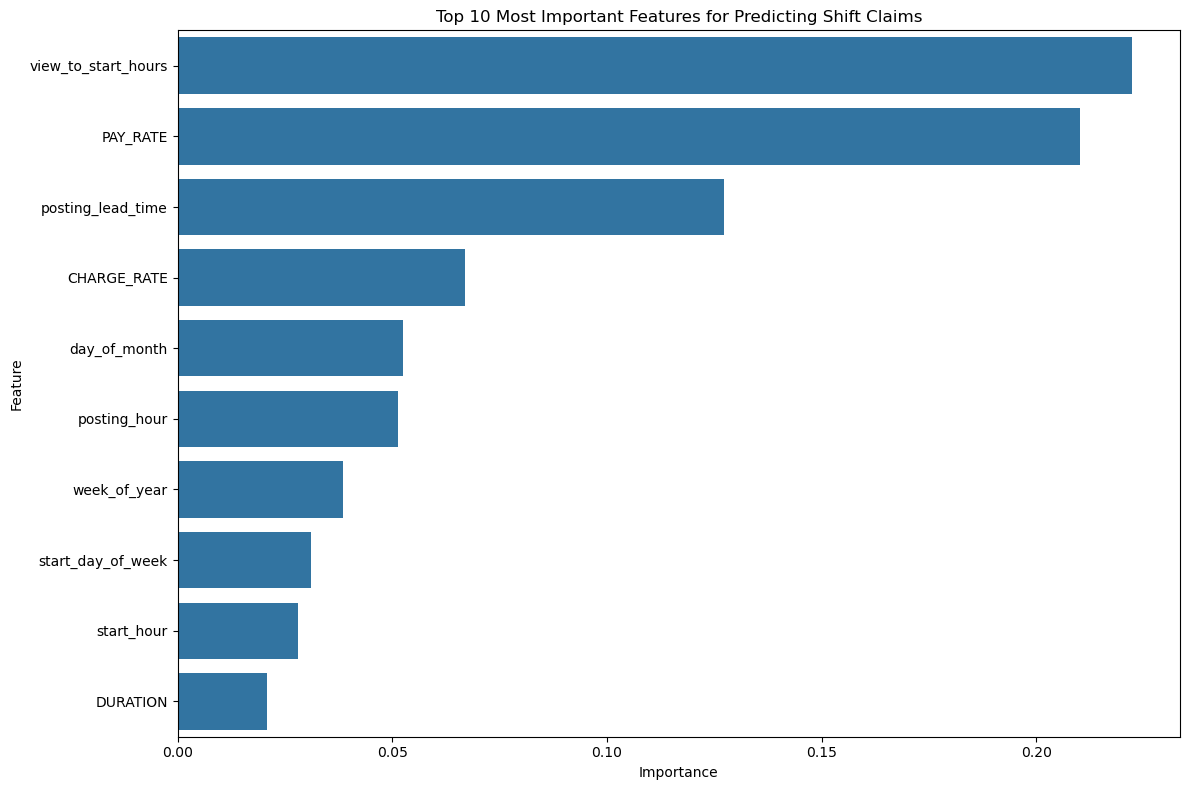

In [106]:
# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Most Important Features for Predicting Shift Claims')
plt.tight_layout()
plt.savefig('feature_importances_no_verified.png')
plt.show()

In [107]:
# Evaluate model performance
y_pred = rf.predict(X_test_scaled)
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("\nModel Performance (without is_verified):")
print(classification_report(y_test, y_pred))


Model Performance (without is_verified):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     76027
           1       0.40      0.15      0.21      3875

    accuracy                           0.95     79902
   macro avg       0.68      0.57      0.59     79902
weighted avg       0.93      0.95      0.94     79902



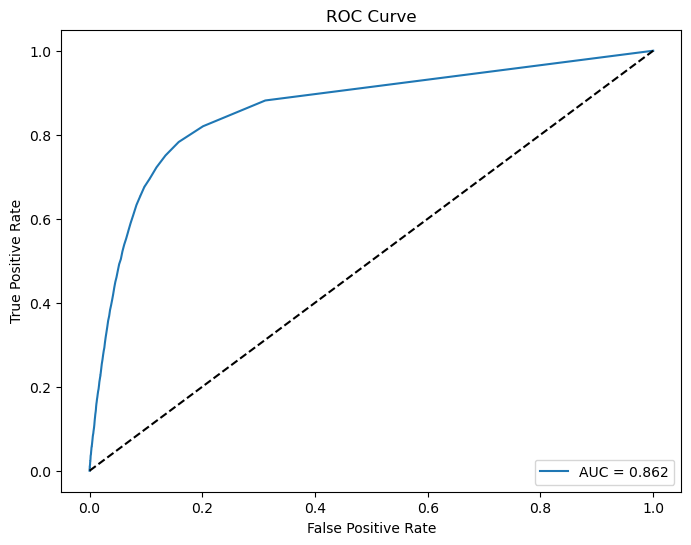

In [108]:
# ROC curve and AUC
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve_no_verified.png')
plt.show()

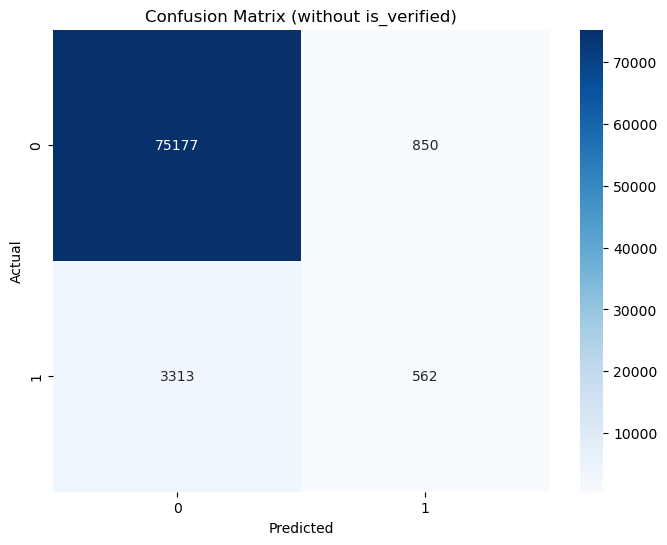

In [109]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (without is_verified)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix_no_verified.png')
plt.show()

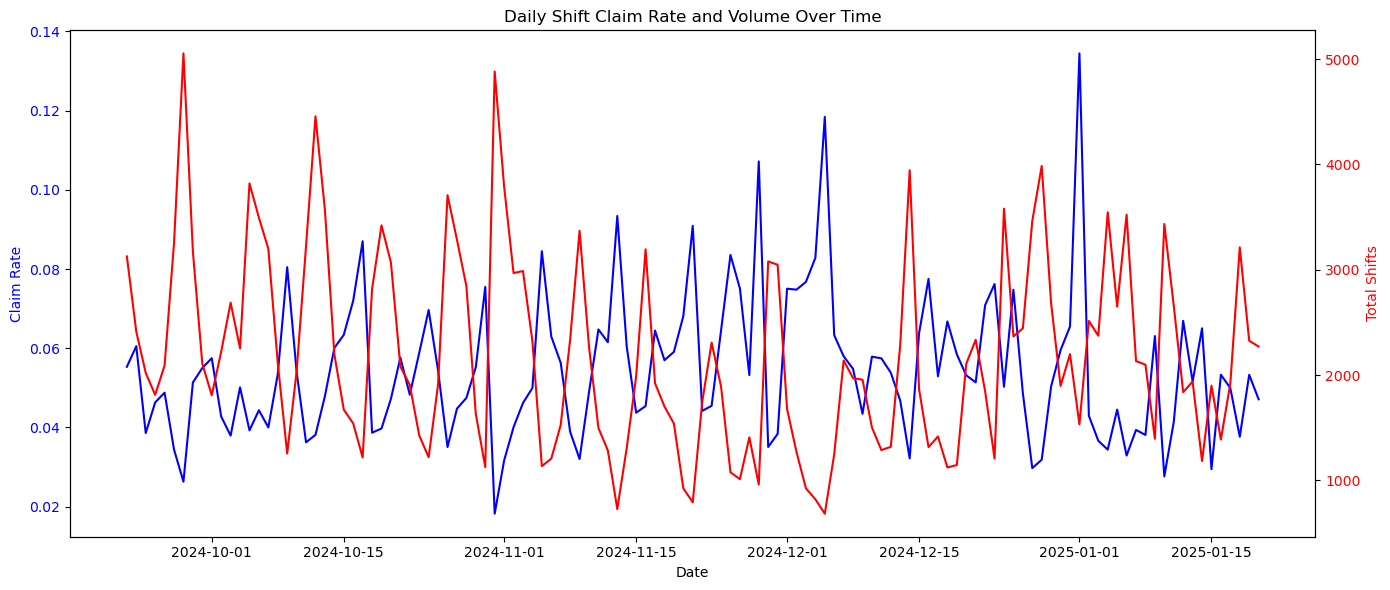

In [111]:
# 1. Time series analysis of claim rates
if 'SHIFT_START_AT' in df.columns:
    df['shift_date'] = df['SHIFT_START_AT'].dt.date
    claim_data = df.groupby('shift_date').agg({
        'is_claimed': ['mean', 'count']
    })
    claim_data.columns = ['claim_rate', 'total_shifts']
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(claim_data.index, claim_data['claim_rate'], 'b-')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Claim Rate', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(claim_data.index, claim_data['total_shifts'], 'r-')
    ax2.set_ylabel('Total Shifts', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title('Daily Shift Claim Rate and Volume Over Time')
    plt.tight_layout()
    plt.savefig('daily_claim_rate_and_volume.png')
    plt.show()

Creating pay rate vs duration density plots...
Number of shifts: 266340
Number of claimed shifts: 13064
Number of unclaimed shifts: 253276


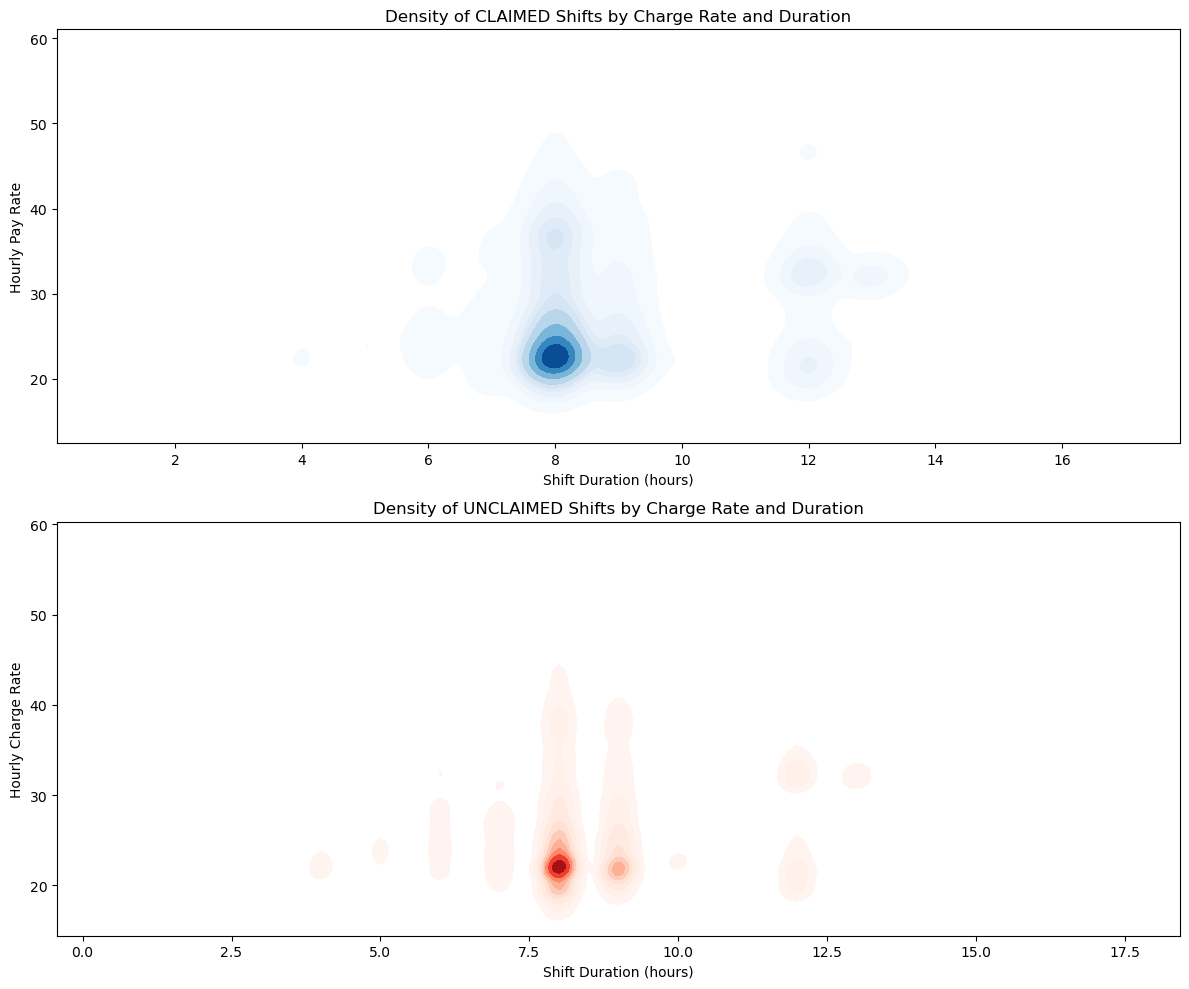

Plot saved as 'charge_rate_duration_density.png'


In [112]:
# 2. Rate vs. Duration analysis with density heatmap
if 'CHARGE_RATE' in df.columns and 'DURATION' in df.columns:
    # Print some information about the data
    print("Creating pay rate vs duration density plots...")
    print(f"Number of shifts: {len(df)}")
    print(f"Number of claimed shifts: {len(df[df['is_claimed'] == 1])}")
    print(f"Number of unclaimed shifts: {len(df[df['is_claimed'] == 0])}")
    
    # Claimed shifts
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    claimed_df = df[df['is_claimed'] == 1]
    if len(claimed_df) > 0:
        sns.kdeplot(x='DURATION', y='PAY_RATE', data=claimed_df, cmap="Blues", fill=True)
        plt.title('Density of CLAIMED Shifts by Charge Rate and Duration')
        plt.xlabel('Shift Duration (hours)')
        plt.ylabel('Hourly Pay Rate')
    else:
        plt.text(0.5, 0.5, 'No claimed shifts data', horizontalalignment='center', verticalalignment='center')
    
    plt.subplot(2, 1, 2)
    unclaimed_df = df[df['is_claimed'] == 0]
    if len(unclaimed_df) > 0:
        sns.kdeplot(x='DURATION', y='PAY_RATE', data=unclaimed_df, cmap="Reds", fill=True)
        plt.title('Density of UNCLAIMED Shifts by Charge Rate and Duration')
        plt.xlabel('Shift Duration (hours)')
        plt.ylabel('Hourly Charge Rate')
    else:
        plt.text(0.5, 0.5, 'No unclaimed shifts data', horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('charge_rate_duration_density.png')
    plt.show()
    print("Plot saved as 'charge_rate_duration_density.png'")


C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\1997767200.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_time_data = df.groupby('lead_time_bin').agg({


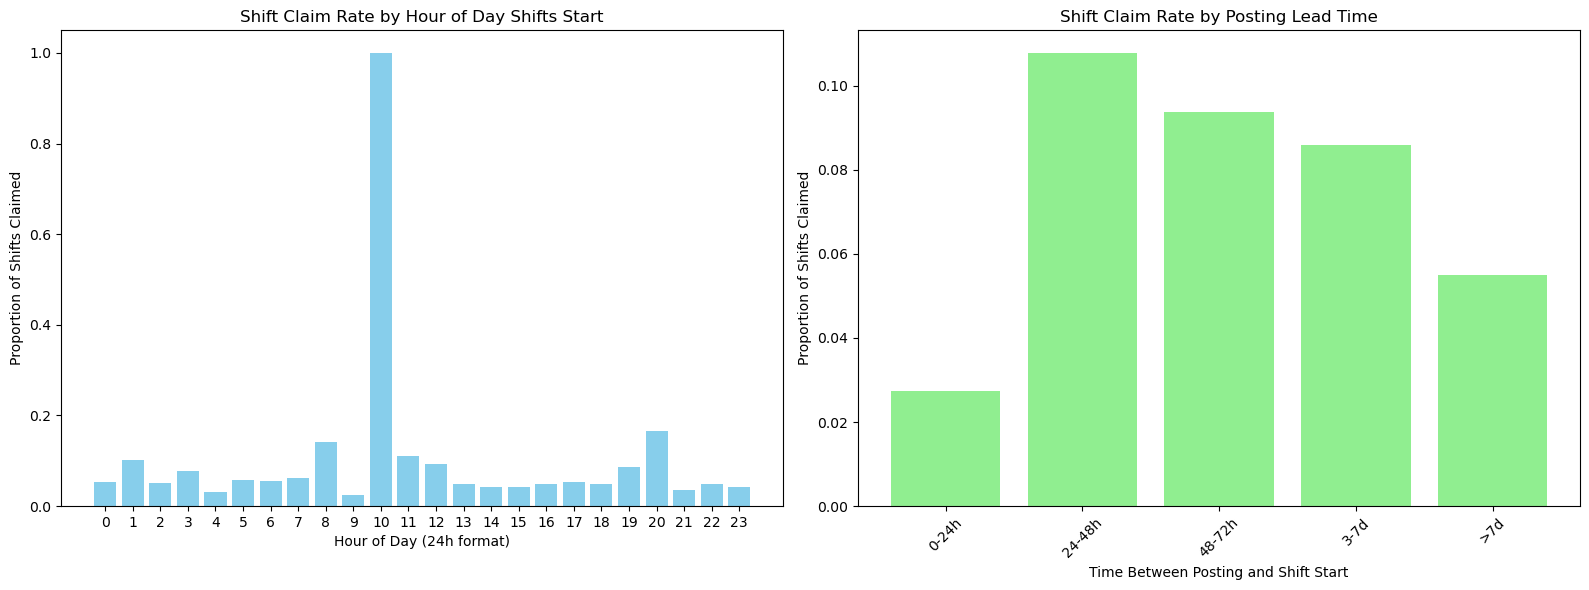

In [113]:
# 3. Time of day and lead time analysis
if 'SHIFT_START_AT' in df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Hour of day analysis
    df['hour_of_day'] = df['SHIFT_START_AT'].dt.hour
    hourly_data = df.groupby('hour_of_day').agg({
        'is_claimed': ['mean', 'count']
    }).reset_index()
    hourly_data.columns = ['hour', 'claim_rate', 'count']
    
    ax1.bar(hourly_data['hour'], hourly_data['claim_rate'], color='skyblue')
    ax1.set_title('Shift Claim Rate by Hour of Day Shifts Start')
    ax1.set_xlabel('Hour of Day (24h format)')
    ax1.set_ylabel('Proportion of Shifts Claimed')
    ax1.set_xticks(range(0, 24, 1))
    
    # Lead time analysis (binned)
    df['lead_time_bin'] = pd.cut(df['posting_lead_time'], 
                                bins=[0, 24, 48, 72, 168, float('inf')],
                                labels=['0-24h', '24-48h', '48-72h', '3-7d', '>7d'])
    
    lead_time_data = df.groupby('lead_time_bin').agg({
        'is_claimed': ['mean', 'count']
    }).reset_index()
    lead_time_data.columns = ['lead_time', 'claim_rate', 'count']
    
    ax2.bar(lead_time_data['lead_time'], lead_time_data['claim_rate'], color='lightgreen')
    ax2.set_title('Shift Claim Rate by Posting Lead Time')
    ax2.set_xlabel('Time Between Posting and Shift Start')
    ax2.set_ylabel('Proportion of Shifts Claimed')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('hour_and_leadtime_analysis.png')
    plt.show()

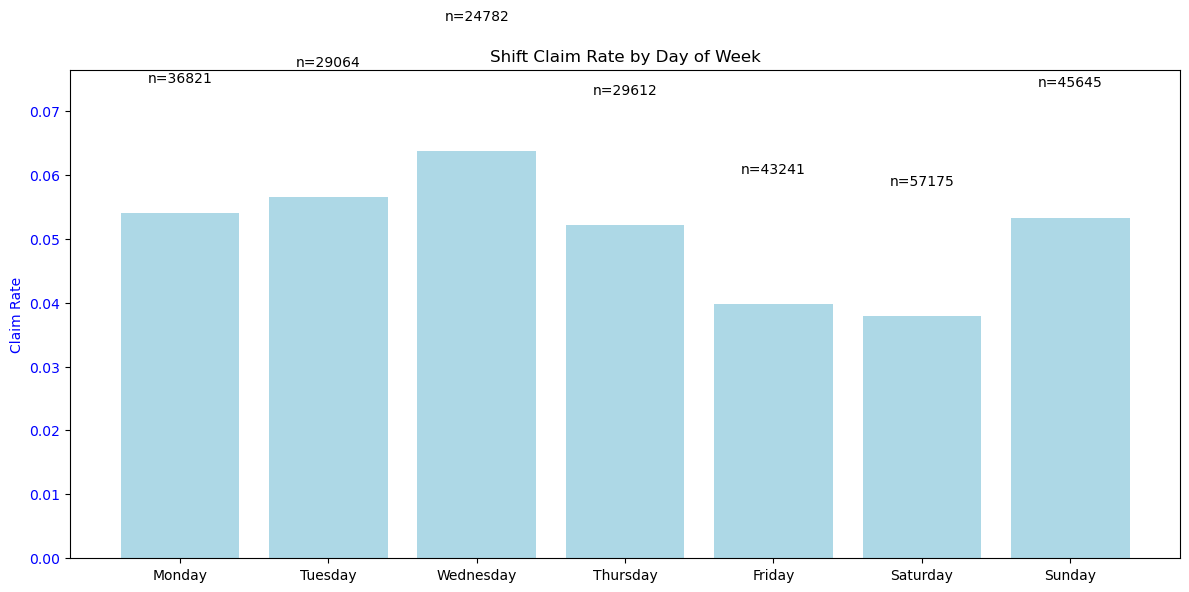

In [114]:
# 4. Day of week analysis with shift counts
if 'SHIFT_START_AT' in df.columns:
    df['day_of_week'] = df['SHIFT_START_AT'].dt.dayofweek
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    day_data = df.groupby('day_of_week').agg({
        'is_claimed': ['mean', 'count']
    }).reset_index()
    day_data.columns = ['day', 'claim_rate', 'count']
    day_data['day_name'] = day_data['day'].apply(lambda x: day_names[x])
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    bars = ax1.bar(day_data['day_name'], day_data['claim_rate'], color='lightblue')
    ax1.set_ylabel('Claim Rate', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0, max(day_data['claim_rate']) * 1.2)
    
    # Add count as text on bars
    for i, bar in enumerate(bars):
        count = day_data.iloc[i]['count']
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'n={count}', ha='center', va='bottom', color='black')
    
    plt.title('Shift Claim Rate by Day of Week')
    plt.tight_layout()
    plt.savefig('day_of_week_claim_rate.png')
    plt.show()

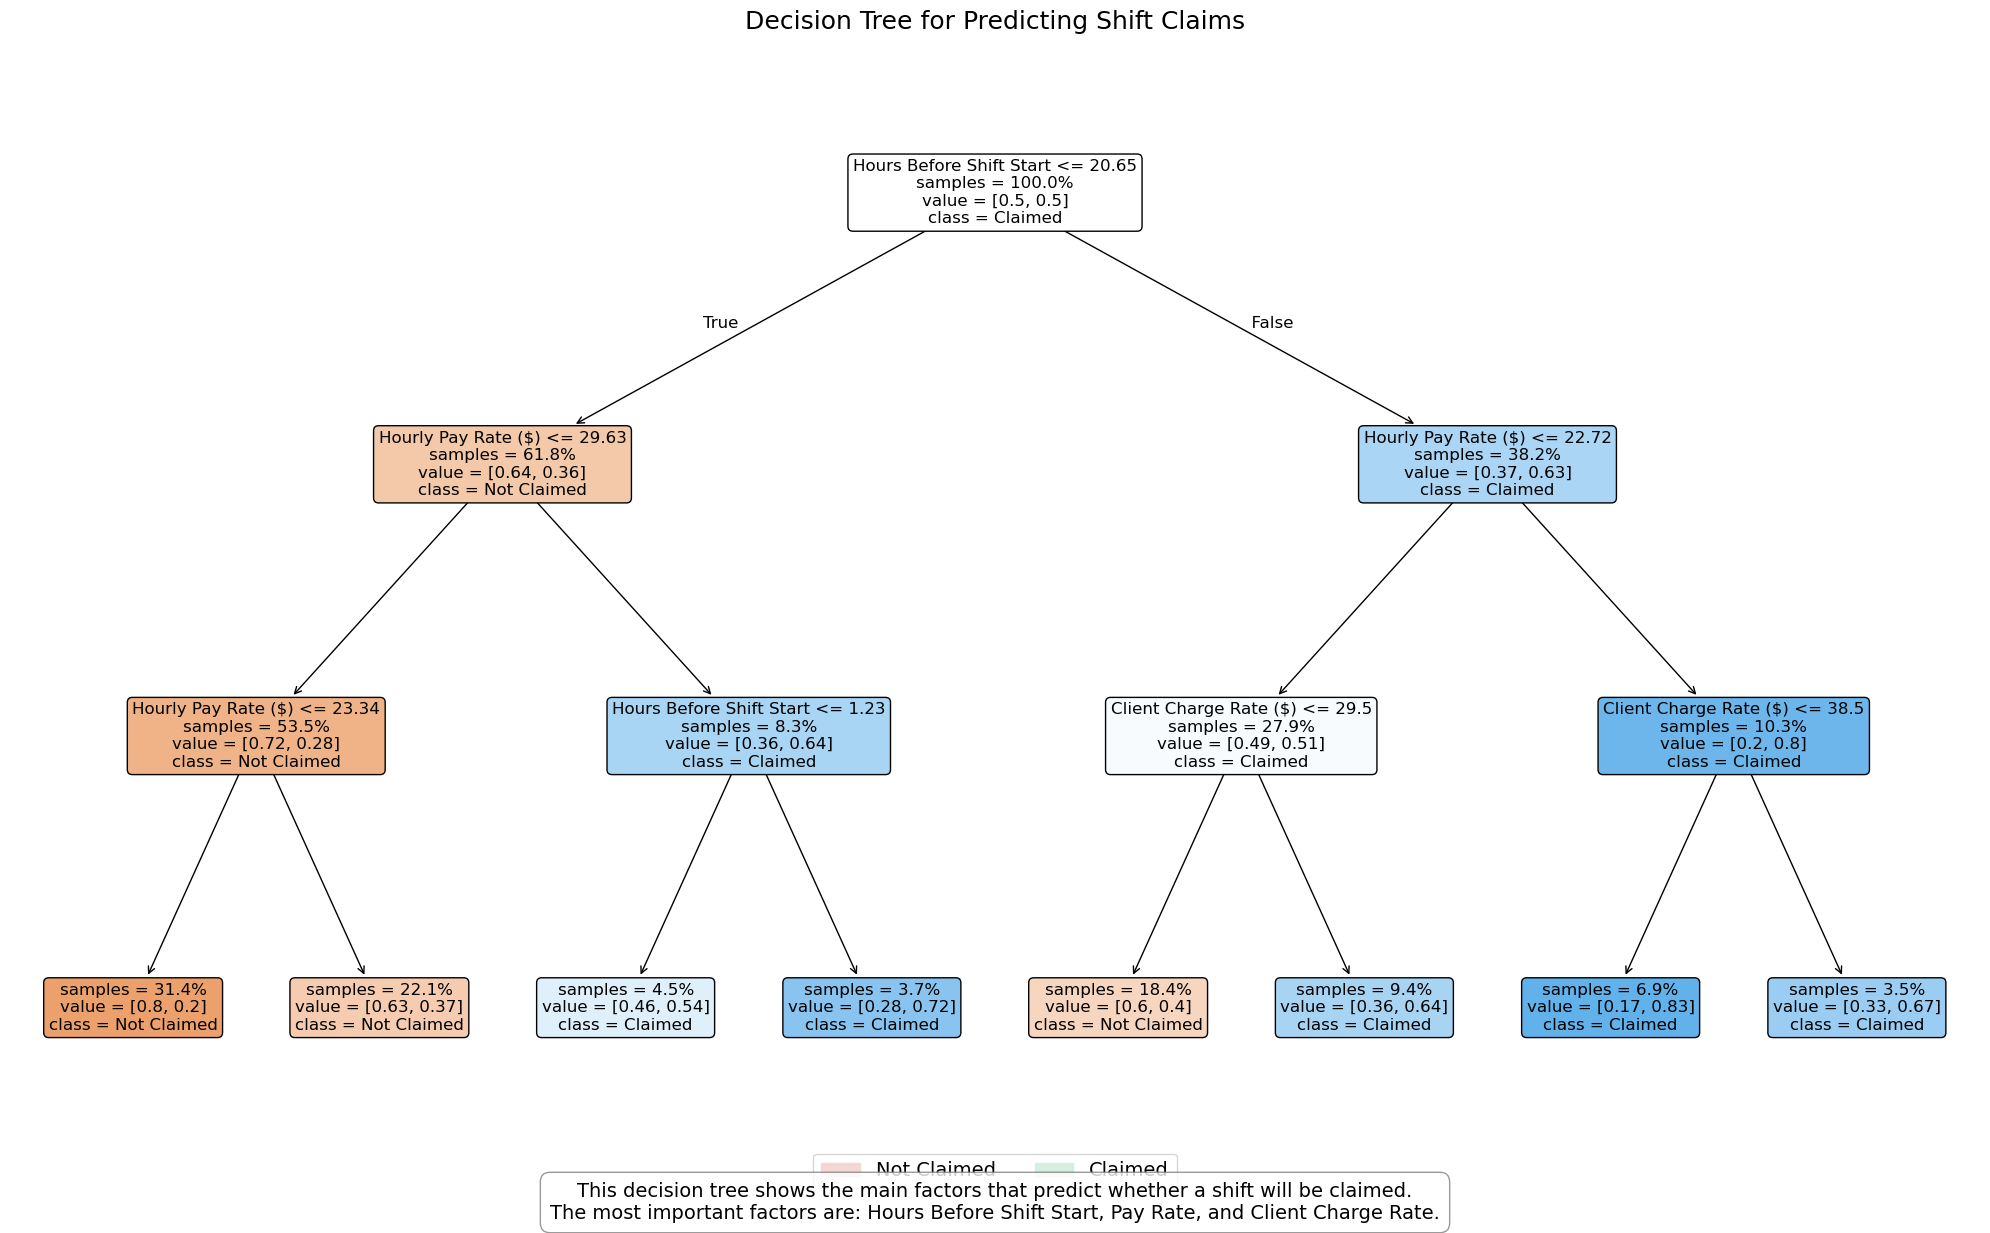


Feature Importance:
                         Feature  Importance
2            Hourly Pay Rate ($)    0.494638
8       Hours Before Shift Start    0.401741
3         Client Charge Rate ($)    0.103621
0                       DURATION    0.000000
28  posted_during_business_hours    0.000000
22               is_end_of_month    0.000000
23                  short_notice    0.000000
24                 medium_notice    0.000000
25                   long_notice    0.000000
26              same_day_posting    0.000000
27                  posting_hour    0.000000
30                   short_shift    0.000000
29             posted_on_weekend    0.000000
20                  day_of_month    0.000000
31                  medium_shift    0.000000
32                    long_shift    0.000000
33                       slot_am    0.000000
34                      slot_noc    0.000000
21             is_start_of_month    0.000000
18                     is_winter    0.000000
19                  week_of_year  

In [115]:
dt = DecisionTreeClassifier(
    max_depth=3,
    random_state=42,
    class_weight='balanced',
    min_samples_split=30,  # Prevent overfitting
    min_samples_leaf=20    # Ensure each leaf has enough samples
)
dt.fit(X_train, y_train)

# 2. Improve feature names for better readability
# Adjust these based on your actual column names
feature_mapping = {
    'view_to_start_hours': 'Hours Before Shift Start',
    'PAY_RATE': 'Hourly Pay Rate ($)',
    'CHARGE_RATE': 'Client Charge Rate ($)'
}

better_feature_names = [feature_mapping.get(col, col) for col in X.columns]

# 3. Create custom colors for better visualization
# Using distinct colors that work well for colorblind viewers
node_colors = ['#f2d7d5', '#d4efdf']  # Light red for Not Claimed, Light green for Claimed
cmap = ListedColormap(node_colors)
# 4. Create the improved visualization
plt.figure(figsize=(20, 12))
plot_tree(
    dt, 
    feature_names=better_feature_names,
    class_names=['Not Claimed', 'Claimed'],
    filled=True,
    rounded=True,
    fontsize=12,
    precision=2,  # Reduce decimal places in displayed numbers
    proportion=True,  # Show proportions instead of counts
    impurity=False,   # Hide impurity to reduce clutter
)

# 5. Add a more informative title and annotations
plt.title('Decision Tree for Predicting Shift Claims', fontsize=18, pad=20)

# 6. Add a legend explaining the colors
import matplotlib.patches as mpatches
not_claimed_patch = mpatches.Patch(color=node_colors[0], label='Not Claimed')
claimed_patch = mpatches.Patch(color=node_colors[1], label='Claimed')
plt.legend(handles=[not_claimed_patch, claimed_patch], 
           loc='lower center', 
           bbox_to_anchor=(0.5, -0.05),
           fontsize=14,
           ncol=2)
# 7. Add overall explanation text
explanation = (
    "This decision tree shows the main factors that predict whether a shift will be claimed.\n"
    "The most important factors are: Hours Before Shift Start, Pay Rate, and Client Charge Rate."
)
plt.figtext(0.5, -0.02, explanation, ha='center', fontsize=14, 
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

# 8. Save with higher quality and better naming
plt.tight_layout()
plt.savefig('improved_decision_tree.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

# 9. Print feature importance for additional context
importance = dt.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': better_feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 10. Optional: Export the decision rules in plain text for easier interpretation
from sklearn.tree import export_text
tree_rules = export_text(dt, feature_names=better_feature_names)
print("\nDecision Rules:")
print(tree_rules)

C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\3807588381.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_bin = df.groupby('pay_bin')['is_claimed'].mean().reset_index()


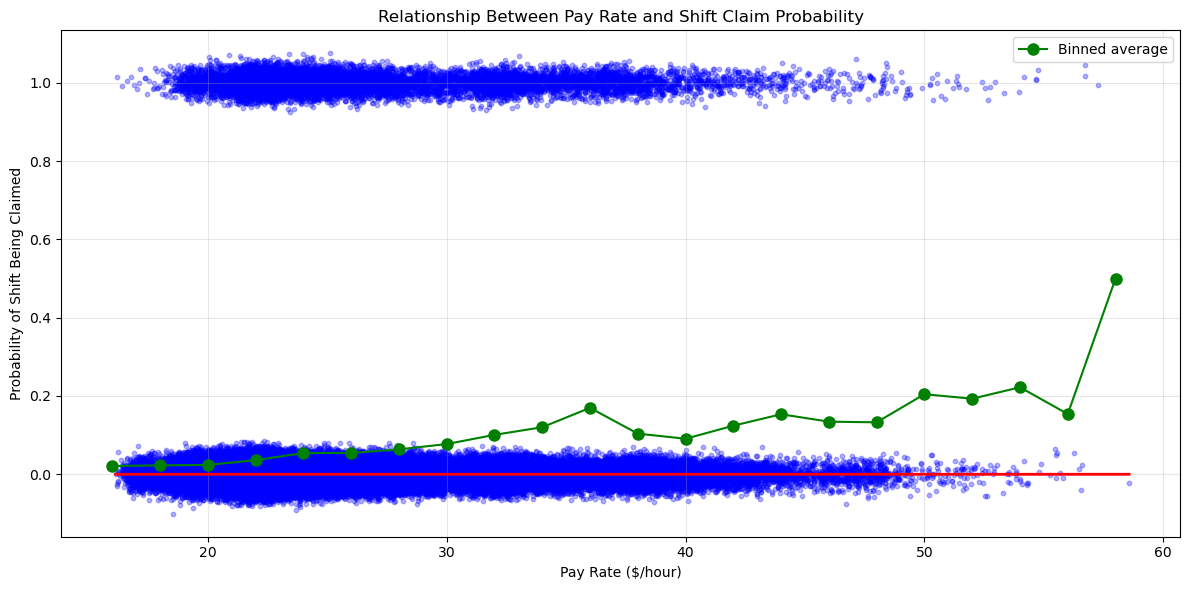

C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\3807588381.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pay_stats = df.groupby('detailed_pay_bin').agg({


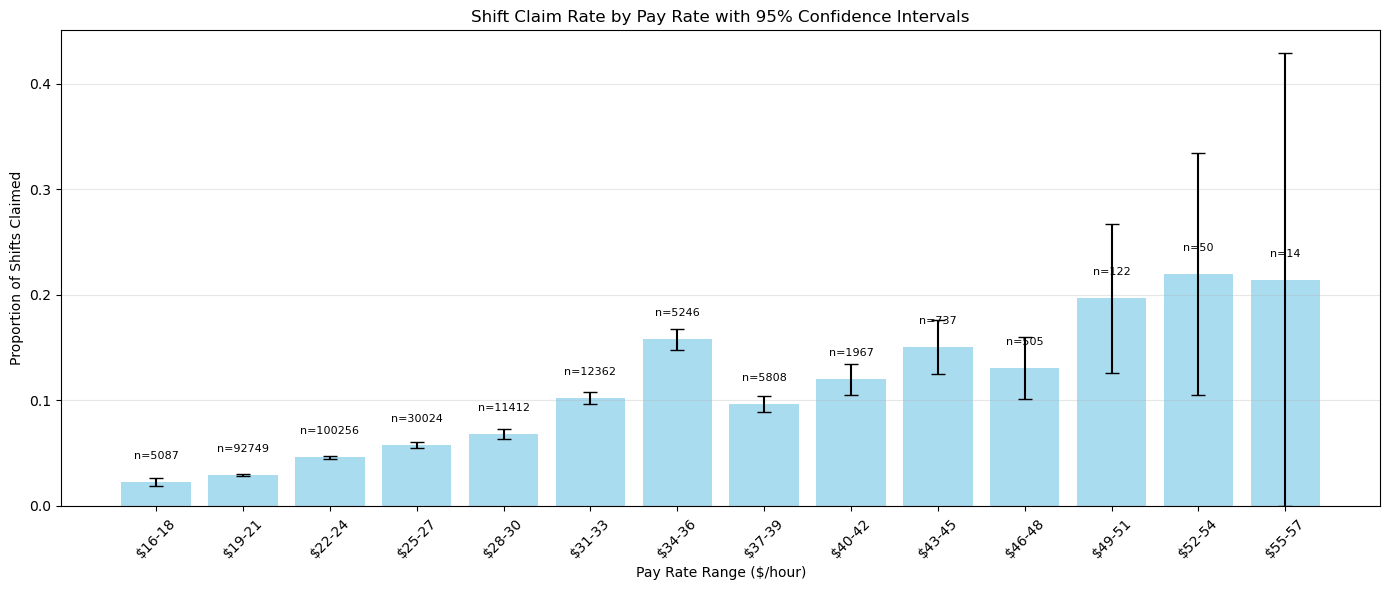

C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\3807588381.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['pay_quartile', 'lead_time_group']).agg({


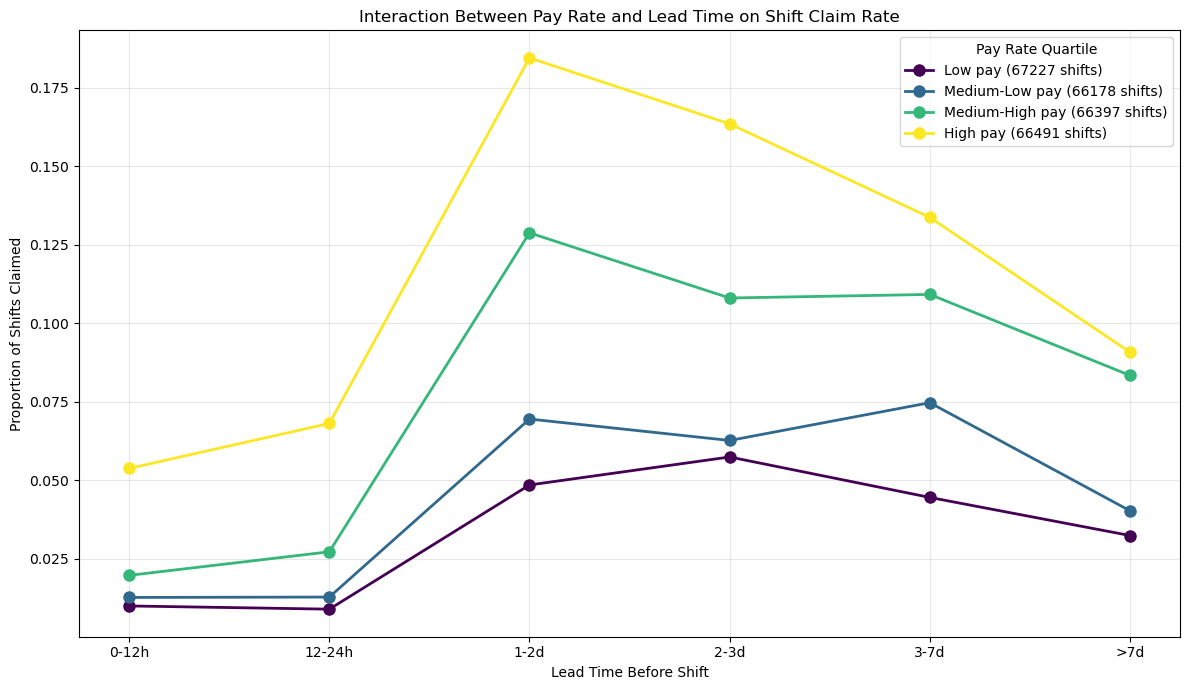

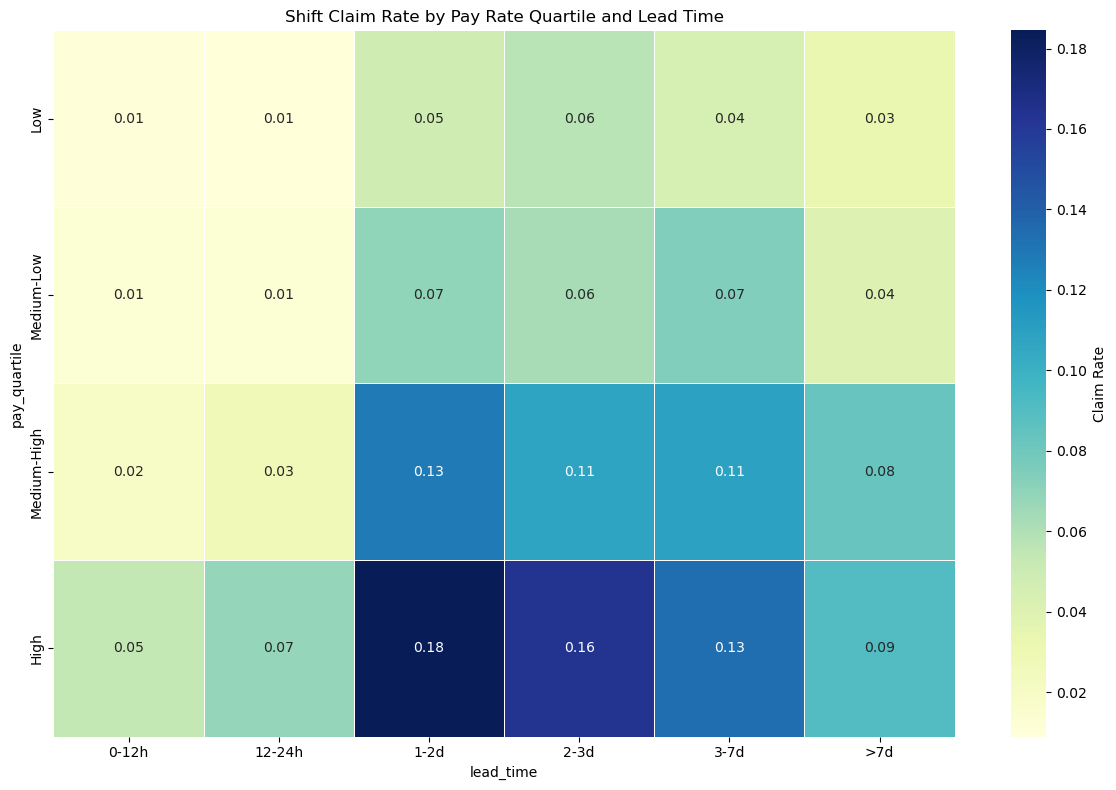

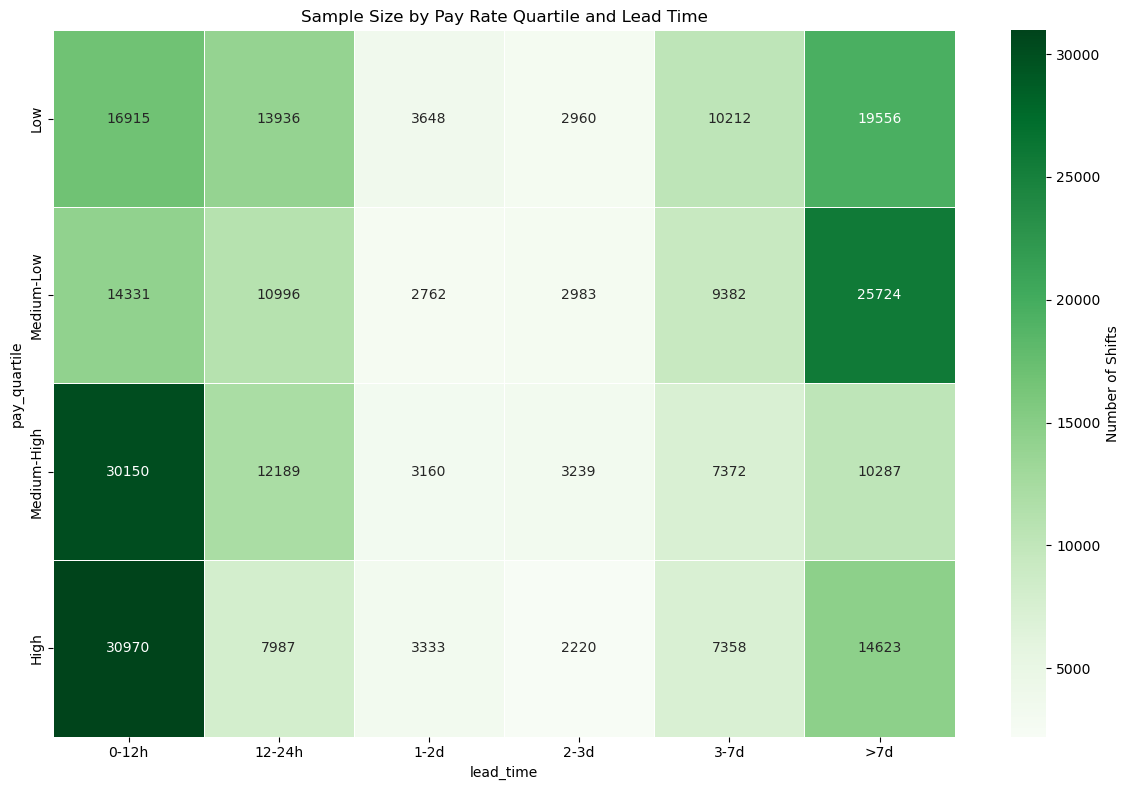

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pay rate as a continuous variable (scatter plot with trend line)
plt.figure(figsize=(12, 6))

# Create small random jitter to show density better
jitter = np.random.normal(0, 0.02, size=len(df))
plt.scatter(df['PAY_RATE'], df['is_claimed'] + jitter, alpha=0.3, 
            color='blue', s=10)

# Add LOWESS smoothing curve to see the trend
sns.regplot(x='PAY_RATE', y='is_claimed', data=df, scatter=False, 
            lowess=True, line_kws={"color": "red", "lw": 2})

# Add binned averages to see the grouped trend
pay_bins = np.arange(15, 60, 2)  # 2-dollar bins
bin_centers = pay_bins[:-1] + 1
df['pay_bin'] = pd.cut(df['PAY_RATE'], bins=pay_bins)
avg_by_bin = df.groupby('pay_bin')['is_claimed'].mean().reset_index()
avg_by_bin['bin_center'] = bin_centers[:len(avg_by_bin)]
plt.plot(avg_by_bin['bin_center'], avg_by_bin['is_claimed'], 
         'o-', color='green', markersize=8, label='Binned average')

plt.xlabel('Pay Rate ($/hour)')
plt.ylabel('Probability of Shift Being Claimed')
plt.title('Relationship Between Pay Rate and Shift Claim Probability')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('pay_rate_trend.png')
plt.show()

# 2. Pay rate bins with confidence intervals
plt.figure(figsize=(14, 6))

# Create more detailed pay rate bins for analysis
detailed_bins = np.arange(16, 60, 3)  # 3-dollar bins
labels = [f'${b}-{b+2}' for b in detailed_bins[:-1]]
df['detailed_pay_bin'] = pd.cut(df['PAY_RATE'], 
                              bins=detailed_bins, 
                              labels=labels)

# Calculate claim rate and confidence intervals
pay_stats = df.groupby('detailed_pay_bin').agg({
    'is_claimed': ['mean', 'count']
}).reset_index()
pay_stats.columns = ['pay_bin', 'claim_rate', 'count']

# Calculate confidence intervals (95%)
z = 1.96  # z-score for 95% confidence
pay_stats['ci_lower'] = pay_stats.apply(
    lambda x: max(0, x['claim_rate'] - z * np.sqrt(x['claim_rate'] * (1-x['claim_rate']) / x['count'])), 
    axis=1)
pay_stats['ci_upper'] = pay_stats.apply(
    lambda x: min(1, x['claim_rate'] + z * np.sqrt(x['claim_rate'] * (1-x['claim_rate']) / x['count'])), 
    axis=1)

# Plot bar chart with error bars
plt.bar(pay_stats['pay_bin'], pay_stats['claim_rate'], alpha=0.7, color='skyblue')
plt.errorbar(range(len(pay_stats)), pay_stats['claim_rate'], 
             yerr=[pay_stats['claim_rate'] - pay_stats['ci_lower'], 
                   pay_stats['ci_upper'] - pay_stats['claim_rate']],
             fmt='none', color='black', capsize=5)

# Annotate with count
for i, row in pay_stats.iterrows():
    plt.text(i, row['claim_rate'] + 0.02, f"n={row['count']}", 
             ha='center', va='bottom', fontsize=8)

plt.xlabel('Pay Rate Range ($/hour)')
plt.ylabel('Proportion of Shifts Claimed')
plt.title('Shift Claim Rate by Pay Rate with 95% Confidence Intervals')
plt.xticks(range(len(pay_stats)), pay_stats['pay_bin'], rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('pay_rate_with_ci.png')
plt.show()

# 3. Combined analysis of pay rate, lead time, and claim rate
if 'posting_lead_time' in df.columns:
    # Create pay rate quartiles
    df['pay_quartile'] = pd.qcut(df['PAY_RATE'], q=4, 
                               labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Create bins for lead time in hours
    lead_hours = [0, 12, 24, 48, 72, 168, float('inf')]
    lead_labels = ['0-12h', '12-24h', '1-2d', '2-3d', '3-7d', '>7d']
    df['lead_time_group'] = pd.cut(df['posting_lead_time'], bins=lead_hours, labels=lead_labels)
    
    # Create the grouped data
    grouped_data = df.groupby(['pay_quartile', 'lead_time_group']).agg({
        'is_claimed': ['mean', 'count']
    }).reset_index()
    grouped_data.columns = ['pay_quartile', 'lead_time', 'claim_rate', 'count']
    
    # Create filtered data with minimum sample size
    min_sample = 20  # Minimum sample size to include
    filtered_data = grouped_data[grouped_data['count'] >= min_sample]
    
    # Create line plot
    plt.figure(figsize=(12, 7))
    
    # Get unique categories for consistent colors
    pay_cats = filtered_data['pay_quartile'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(pay_cats)))
    
    # For each pay quartile, plot a line
    for i, pay_cat in enumerate(pay_cats):
        data = filtered_data[filtered_data['pay_quartile'] == pay_cat]
        plt.plot(data['lead_time'], data['claim_rate'], 'o-', 
                 color=colors[i], linewidth=2, markersize=8, 
                 label=f'{pay_cat} pay ({data["count"].sum()} shifts)')
    
    plt.xlabel('Lead Time Before Shift')
    plt.ylabel('Proportion of Shifts Claimed')
    plt.title('Interaction Between Pay Rate and Lead Time on Shift Claim Rate')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Pay Rate Quartile')
    plt.tight_layout()
    plt.savefig('pay_leadtime_interaction.png')
    plt.show()
    
    # 4. Heatmap of pay rate, lead time, and claim rate
    # Create a pivot table
    pivot_data = filtered_data.pivot(index='pay_quartile', columns='lead_time', values='claim_rate')
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.2f', 
                linewidths=.5, cbar_kws={'label': 'Claim Rate'})
    plt.title('Shift Claim Rate by Pay Rate Quartile and Lead Time')
    plt.tight_layout()
    plt.savefig('pay_leadtime_heatmap_detailed.png')
    plt.show()
    
    # Create a pivot table for counts (to see sample sizes)
    count_pivot = filtered_data.pivot(index='pay_quartile', columns='lead_time', values='count')
    
    # Plot count heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(count_pivot, annot=True, cmap='Greens', fmt='d', 
                linewidths=.5, cbar_kws={'label': 'Number of Shifts'})
    plt.title('Sample Size by Pay Rate Quartile and Lead Time')
    plt.tight_layout()
    plt.savefig('pay_leadtime_counts.png')
    plt.show()

C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\2736100263.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pay_rate_data = df.groupby('pay_rate_bin').agg({
C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\2736100263.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  view_time_data = df.groupby('view_to_start_bin').agg({
C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\2736100263.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and si

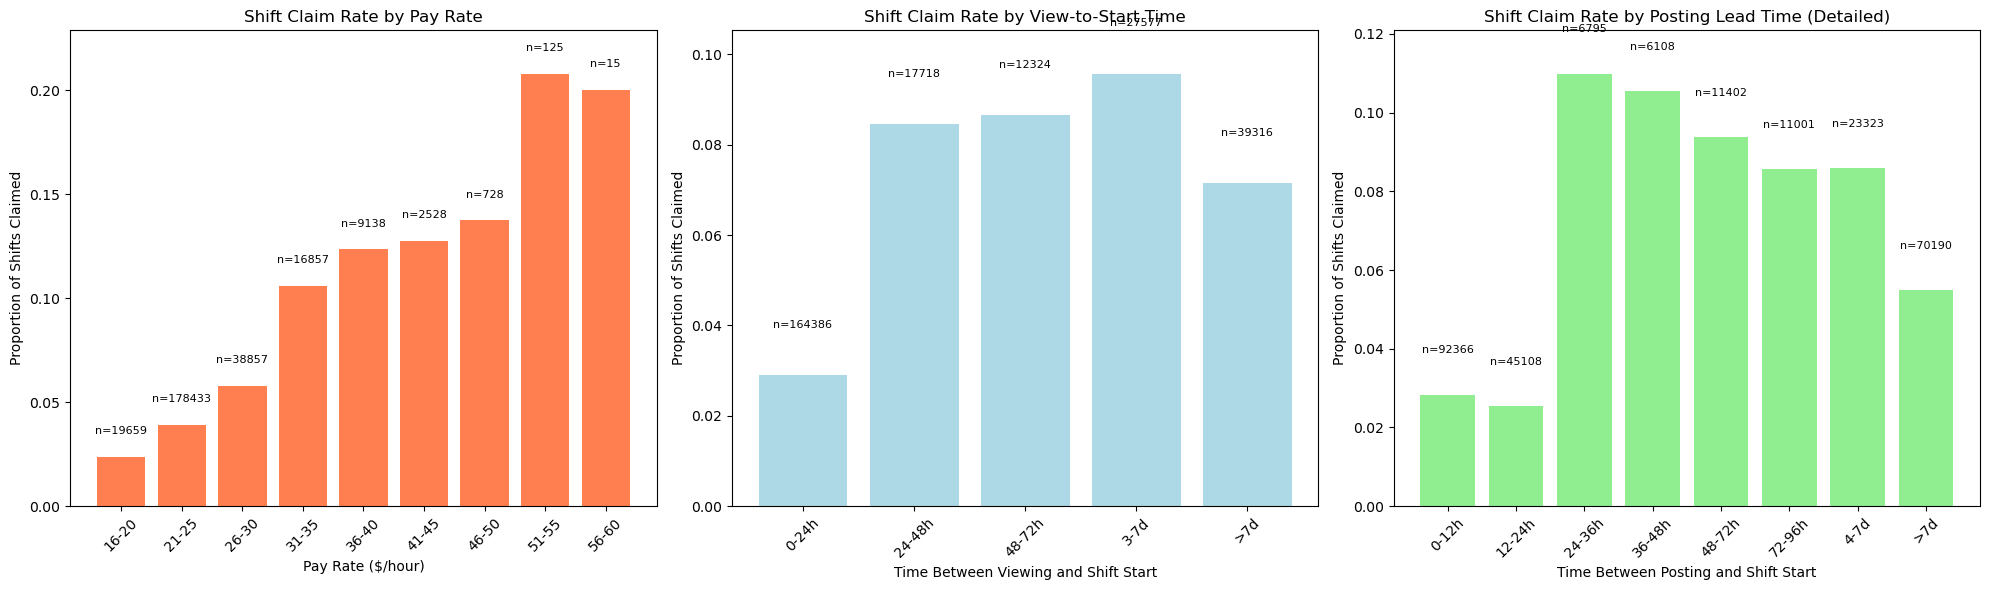

C:\Users\Ethan\AppData\Local\Temp\ipykernel_26780\2736100263.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cross_data = df.groupby(['pay_rate_simple', 'lead_time_simple']).agg({


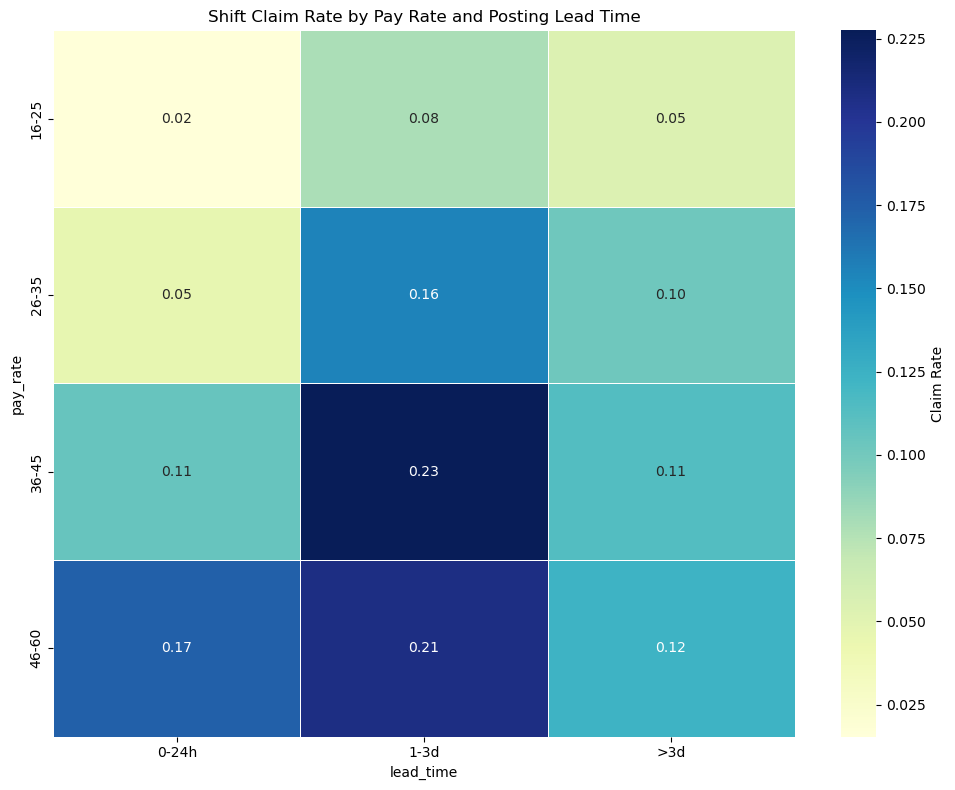

Sample sizes for each combination:
lead_time  0-24h   1-3d    >3d
pay_rate                      
16-25      97244  18647  82187
26-35      34230   4113  17346
36-45       5712   1468   4479
46-60        288     77    502


In [117]:
# Pay rate analysis similar to hour of day and lead time
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. Pay rate analysis
# Create bins for pay rate
df['pay_rate_bin'] = pd.cut(df['PAY_RATE'], 
                         bins=[15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
                         labels=['16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60'])

pay_rate_data = df.groupby('pay_rate_bin').agg({
    'is_claimed': ['mean', 'count']
}).reset_index()
pay_rate_data.columns = ['pay_rate', 'claim_rate', 'count']

# Plot claim rate by pay rate
ax1.bar(pay_rate_data['pay_rate'], pay_rate_data['claim_rate'], color='coral')
ax1.set_title('Shift Claim Rate by Pay Rate')
ax1.set_xlabel('Pay Rate ($/hour)')
ax1.set_ylabel('Proportion of Shifts Claimed')
ax1.set_ylim(0, max(pay_rate_data['claim_rate']) * 1.1)  # Set y-axis limit with 10% margin
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Annotate with count
for i, row in pay_rate_data.iterrows():
    ax1.text(i, row['claim_rate'] + 0.01, f"n={row['count']}", 
             ha='center', va='bottom', fontsize=8)

# 2. View to start hours analysis (if available)
if 'view_to_start_hours' in df.columns:
    # Create bins for view to start hours (time between viewing and shift start)
    df['view_to_start_bin'] = pd.cut(df['view_to_start_hours'], 
                                   bins=[0, 24, 48, 72, 168, float('inf')],
                                   labels=['0-24h', '24-48h', '48-72h', '3-7d', '>7d'])
    
    view_time_data = df.groupby('view_to_start_bin').agg({
        'is_claimed': ['mean', 'count']
    }).reset_index()
    view_time_data.columns = ['view_time', 'claim_rate', 'count']
    
    ax2.bar(view_time_data['view_time'], view_time_data['claim_rate'], color='lightblue')
    ax2.set_title('Shift Claim Rate by View-to-Start Time')
    ax2.set_xlabel('Time Between Viewing and Shift Start')
    ax2.set_ylabel('Proportion of Shifts Claimed')
    ax2.set_ylim(0, max(view_time_data['claim_rate']) * 1.1)  # Set y-axis limit with 10% margin
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Annotate with count
    for i, row in view_time_data.iterrows():
        ax2.text(i, row['claim_rate'] + 0.01, f"n={row['count']}", 
                 ha='center', va='bottom', fontsize=8)
else:
    ax2.text(0.5, 0.5, 'view_to_start_hours not available', 
             ha='center', va='center', transform=ax2.transAxes)

# 3. Enhanced posting lead time analysis
if 'posting_lead_time' in df.columns:
    # Create detailed bins for posting lead time
    df['detailed_lead_time_bin'] = pd.cut(df['posting_lead_time'], 
                                    bins=[0, 12, 24, 36, 48, 72, 96, 168, float('inf')],
                                    labels=['0-12h', '12-24h', '24-36h', '36-48h', '48-72h', '72-96h', '4-7d', '>7d'])
    
    detailed_lead_time_data = df.groupby('detailed_lead_time_bin').agg({
        'is_claimed': ['mean', 'count']
    }).reset_index()
    detailed_lead_time_data.columns = ['lead_time', 'claim_rate', 'count']
    
    ax3.bar(detailed_lead_time_data['lead_time'], detailed_lead_time_data['claim_rate'], color='lightgreen')
    ax3.set_title('Shift Claim Rate by Posting Lead Time (Detailed)')
    ax3.set_xlabel('Time Between Posting and Shift Start')
    ax3.set_ylabel('Proportion of Shifts Claimed')
    ax3.set_ylim(0, max(detailed_lead_time_data['claim_rate']) * 1.1)  # Set y-axis limit with 10% margin
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Annotate with count
    for i, row in detailed_lead_time_data.iterrows():
        ax3.text(i, row['claim_rate'] + 0.01, f"n={row['count']}", 
                 ha='center', va='bottom', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'posting_lead_time not available', 
             ha='center', va='center', transform=ax3.transAxes)

plt.tight_layout()
plt.savefig('pay_rate_view_leadtime_analysis.png')
plt.show()


# Additional analysis: Pay rate and posting lead time interaction
if 'posting_lead_time' in df.columns and 'PAY_RATE' in df.columns:
    # Create a simpler pay rate bin for cross-analysis
    df['pay_rate_simple'] = pd.cut(df['PAY_RATE'], 
                                bins=[15, 25, 35, 45, 60],
                                labels=['16-25', '26-35', '36-45', '46-60'])
    
    # Create a simpler lead time bin for cross-analysis
    df['lead_time_simple'] = pd.cut(df['posting_lead_time'], 
                                  bins=[0, 24, 72, float('inf')],
                                  labels=['0-24h', '1-3d', '>3d'])
    
    # Cross-tabulate pay rate and lead time
    cross_data = df.groupby(['pay_rate_simple', 'lead_time_simple']).agg({
        'is_claimed': ['mean', 'count']
    }).reset_index()
    cross_data.columns = ['pay_rate', 'lead_time', 'claim_rate', 'count']
    
    # Create a pivot table for heatmap
    pivot_data = cross_data.pivot(index='pay_rate', columns='lead_time', values='claim_rate')
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.2f', 
                linewidths=.5, cbar_kws={'label': 'Claim Rate'})
    plt.title('Shift Claim Rate by Pay Rate and Posting Lead Time')
    plt.tight_layout()
    plt.savefig('pay_rate_leadtime_heatmap.png')
    plt.show()
    
    # Count data for context
    count_pivot = cross_data.pivot(index='pay_rate', columns='lead_time', values='count')
    print("Sample sizes for each combination:")
    print(count_pivot)